In [1]:
%matplotlib inline


Hi Lisa. 

This is kind of a sketch of how the fitting should work for data. In this case, the orbital period is fixed, and i tested it on data that doesnt contain an eclipse. I think you would want to fit for the period. There are a few other parameters that are fixed: (semimajor axis, period, eccentricity, longitude at periastron). Eccentricity might be another good one to add to the variables. I dont know about the other two. 

IMPORTANT: For the phase model: you want to fix values for planet radius, temperature of the star and all the stuff that is mentioned in the example. You can only fit for tau_rad and w_adv with that model. Small changes in planet radius and stuff won't make a difference anyways, fit for those with the transit model.  

You might wanna experiment with step size settings till you get something smooth that's still pretty fast, it could vary. That part might be interesting to automate. 

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import scipy
from matplotlib.ticker import MaxNLocator
import emcee
import batman 
import time as tm
import healpy as hp
from Parcel_healpy6 import parcel as p
from Parcel_healpy6 import fitter as fit
#import triangle

In [3]:
"Loading data "

time = np.loadtxt('ch2_datacube_binned_AORs234.dat', skiprows=1, usecols=[0])
xdata = np.loadtxt('ch2_datacube_binned_AORs234.dat', usecols=[1],skiprows=1)
ydata = np.loadtxt('ch2_datacube_binned_AORs234.dat', usecols=[2],skiprows=1)
flux = np.loadtxt('ch2_datacube_binned_AORs234.dat', usecols=[3],skiprows=1)
yerror = np.loadtxt('ch2_datacube_binned_AORs234.dat', usecols=[4],skiprows=1)

In [4]:
"Transit model"


def d_sens(x, y, middlex,middley, a, a2, b, b2, c, d):
    'Simple detector model'
    det_sens = np.array(a*(x-middlex)+a2*(y-middley)+b*(x-middlex)**2+
                        b2*(y-middlex)**2+c*(x-middley)*(y-middley)+d)
    return np.array(det_sens)


def batman_model(t, rp, t0, ax , w,inc, ecc, lng,q1,q2, fp):
    """Astro model: Im using this function only to check what the model lightcurve looks like. 
    Includes kind of a stupid cosine for phase variations """
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1-2*q2)
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = t0                        #time of inferior conjunction
    params.per = w                       #orbital period
    params.rp = rp                       #planet radius (in units of stellar radii)
    params.a = ax                        #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = ecc                       #eccentricity
    params.w = lng                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [u1,u2]      #limb darkening coefficients
    
    m = batman.TransitModel(params, t )
    params.fp = fp
    params.t_secondary = m.get_t_secondary(params)
    m2 = batman.TransitModel(params, t, transittype="secondary")
    flux_batman = m.light_curve(params)+m2.light_curve(params)-1 
    return flux_batman
    
def phase_model(planet, tau_rad, wadv) :
    '''tau_rad, wadv'''
    planet.tau_rad = tau_rad*3600.0
    planet.wadv = (2*np.pi/planet.P)*wadv
    Fstar, Fstarwv = planet.Fstar()
    
    t, di, Fwv= planet.Fobs()
  
    return (Fwv/Fstarwv)

def transit_model(t,planet,x, y,middlex, middley, rp, t0, ax, w, inc, ecc, 
                  lng,q1,q2,fp,a, a2, b, b2, c, d,tau_rad, wadv ):
    """This is a transit model including transit, eclipse, polynomial, detector model and 
    phase variations model """
    
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1-2*q2)
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = t0                        #time of inferior conjunction
    params.per = w                       #orbital period
    params.rp = rp                       #planet radius (in units of stellar radii)
    params.a = ax                        #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = ecc                       #eccentricity
    params.w = lng                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [u1,u2]      #limb darkening coefficients
    #return easy_model(t, rp, t0, amp, w, o)*d_sens(x, y, middlex,middley, a, a2, b, b2, c, c2, d) 
    m = batman.TransitModel(params, t ) 
    #params.fp = fp          #planet flux/ star flux, used for eclipse calc. 
    #params.t_secondary = m.get_t_secondary(params) #gets the eclipse time from the first transit time but this 
                                                    #might not be the best way to do it 
    #m2 = batman.TransitModel(params, t, transittype="secondary")

    flux_astro = (m.light_curve(params)+phase_model(planet, tau_rad, wadv))#+m2.light_curve(params)-1  
    
    
    
    return flux_astro*d_sens(x, y, middlex,middley, a, a2, b, b2, c, d)

1.3231259333
regular time
regular time
-68789.674656
transit_t is 882247.05901
[542]
time for stitching is [ 814613.12773981]
observed time


"flux_phase is what we'll be fitting now"

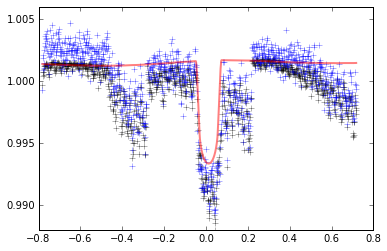

In [6]:

'TRUE VALUES WE NEED'


rp_true = 0.0892 #in stellar radii
rp_phase = rp_true*1/0.10045*(1.49) #in jupiter radii now
print rp_phase


t0_true = 0.0143
t0_phase = t0_true

ax_true =7.057 
ax_phase = ax_true * 1.49 * 0.00465047 # in AU now

w_true = 3.1915
w_phase = w_true

inc_true = 84.09
inc_phase = inc_true

ecc_true = 0.2769
ecc_phase = ecc_true

lng_true = 347.2
lng_phase = lng_true

q1_true = 0.524699052073
q2_true = 0.248583527596
fp_true = 0.00106403273364
#A_phase = 0.00557441065977*10

a_true = -0.0168
a2_true = -0.0638
b_true = -0.387
b2_true = -0.282
c_true = -0.023

d_true = 1.0078

middlex = np.mean(xdata)
middley = np.mean(ydata)

wadv_true = 2
tau_rad_true = 20

'PLANET DEFINITION'

XO_3b = p(name = "XO-3b",Teff = 6781, e=ecc_phase, Porb = w_phase, a = ax_phase, wadv = wadv_true, 
                  tau_rad = tau_rad_true, argp = lng_phase, Rstar = 1.49, Mstar = 1.41, 
                  Rplanet = rp_phase, steps = 100, NSIDE = 4, pmax =3)
XO_3bf = fit(XO_3b, ts = (time-t0_phase)*3600*24,
          me = "XO-3b",Teff = 6781, e=ecc_phase, Porb = w_phase, a = ax_phase, wadv = wadv_true, 
                  tau_rad = tau_rad_true, argp = lng_phase, Rstar = 1.49, Mstar = 1.41, 
                  Rplanet = rp_phase, steps = 100, NSIDE = 4, pmax =3)

planet = XO_3bf

'CALCULATIONG THE MODEL'
transit_phase = batman_model(time,  rp_true, t0_true, ax_true,w_true, inc_phase,ecc_true, lng_true,
                            q1_true, q2_true, fp_true)

full_model = transit_model(time,planet,xdata, ydata,middlex, middley, rp_true, t0_true, ax_true, 
                              w_true, inc_true, ecc_true, 
                  lng_true,q1_true, q2_true, fp_true,a_true, a2_true, b_true, b2_true, c_true, d_true,
                              tau_rad_true, wadv_true )

detector = d_sens(xdata, ydata, middlex,middley, a_true, a2_true, b_true, b2_true, c_true, d_true)

light_curve = full_model/ detector
#gotta fit this quantity
#flux_phase = flux/ (transit_phase)
#plt.plot(time, flux_phase, 'b+')

plt.plot(time, full_model, 'k+', alpha = 0.6)
plt.plot(time, flux, 'b+', alpha = 0.6)
plt.plot(time, light_curve, 'r', linewidth = 2, alpha = 0.5)

"flux_phase is what we'll be fitting now"

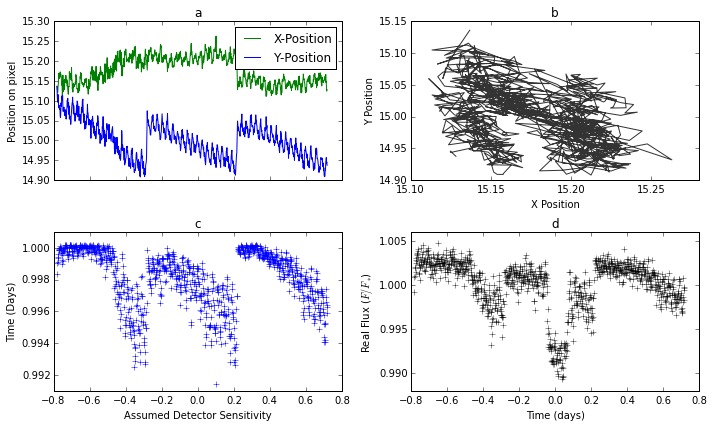

In [61]:
"This is only a figure that will let you look at your data. Doesn't do anything usefull"

fig = plt.figure(figsize = (10,6))

ax1 = plt.subplot2grid((2, 2), (0, 0),colspan=1, rowspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((2, 2), (1, 1), colspan=1,rowspan =1)

xplot, = ax1.plot(time, xdata, 'g', alpha = 1)
yplot, = ax1.plot(time, ydata, 'b', alpha = 1)
ax1.legend([xplot, yplot], ['X-Position', 'Y-Position '])
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=6, mode="expand", borderaxespad=0.)               
ax1.set_title('a')
ax1.set_ylabel("Position on pixel")

ax3.plot(time, detector, linestyle = "None", marker= '+')
ax3.set_title('c')
ax3.set_ylabel('Time (Days)')
ax3.set_xlabel("Assumed Detector Sensitivity")

ax2.set_title('b')
ax2.plot(xdata,ydata, 'k', alpha = 0.8)
ax2.set_xlabel("X Position ")
ax2.set_ylabel("Y Position ")
ax2.get_xticklabels() 

ax4.plot(time, flux, '+k', alpha = 0.8)
ax4.set_title('d')
ax4.set_xlabel("Time (days) ")
ax4.set_ylabel('Real Flux ($F/F_*$)')

plt.setp(ax1.get_xticklabels() , visible=False)
plt.tight_layout()
fig.savefig('XYdata_real2', dpi=300)


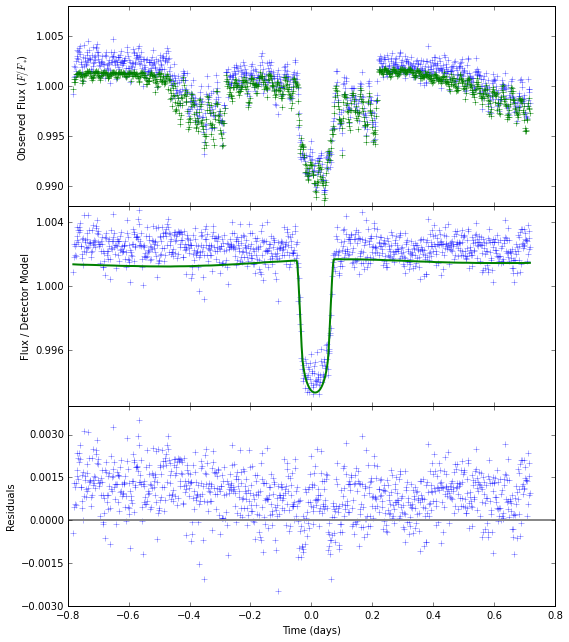

In [62]:
"""Another figure where you can take a guess about your parameters and see 
how well it matches with the real flux. Again, doesn't do anything important"""


fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 9))
axes[0].plot(time, flux, 'b+', linestyle='none',alpha=0.6)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].plot(time, full_model, 'g+', linestyle='none',alpha=1)
axes[0].set_ylabel("Observed Flux ($F/F_*$)")
#axes[0].set_ylim(1.05,1.1)

axes[1].plot(time, flux/detector, 'b+', linestyle='none', alpha=0.6)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].plot(time, light_curve, 'g',alpha=1,lw=2)
axes[1].set_ylabel("Flux / Detector Model")
#axes[1].set_ylim(0.98,1.02)

axes[2].plot(time, flux - full_model, 'b+', linestyle='none',alpha=0.6)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(0, color="#888888", lw=2)
axes[2].set_ylabel("Residuals")
axes[2].set_xlabel("Time (days)")


fig.tight_layout(h_pad=0.0)
fig.savefig('channel2_data.png')
plt.show()

In [65]:
"""Optimization doesn't work. You have to guess your params for now . 
However, the lnlike fubnction is important for the mcmc, don't delete it """




def lnlike(theta, t, planet, flux, x, y, ax, w, ecc, lng, middlex, middley,fp, yerr):
    rp, t0, inc, q1,q2, a, a2, b, b2, c, d, tau_rad, wadv = theta 
    #f is the fractional amount that we're underestimating the error
    model = transit_model(t,planet, x, y,  middlex, middley, rp, t0, ax, w, inc, ecc, 
                          lng, q1, q2 , fp, a, a2, b, b2, c, d, tau_rad, wadv)
    inv_sigma2 = 1.0/(yerr**2 )
    return -0.5*(np.sum((flux-model)**2*inv_sigma2 - np.log(inv_sigma2)))
    



ball = np.random.randn(13)/1000

import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [rp_true, t0_true, inc_true, q1_true,q2_true, 
                           a_true,a2_true, b_true, b2_true, c_true,
                           d_true,tau_rad_true, wadv_true] + ball, method = 'Nelder-Mead',
                     args=(time, planet, flux, xdata, ydata,ax_true,w_true, ecc_true, lng_true, middlex, middley, fp_true, yerror))

rp_ml, t0_ml,inc_ml,q1_ml,q2_ml, a_ml, a2_ml,b_ml, b2_ml, c_ml,d_ml, tau_rad_ml, wadv_ml = result["x"]

print result.message

Maximum number of function evaluations has been exceeded.


  status: 1
    nfev: 2600
 success: False
     fun: -6210.7134902566158
       x: array([  8.96630640e-02,   1.45725451e-02,   8.42453344e+01,
         9.13860315e-02,   2.85795095e-01,  -1.70179194e-02,
        -5.95086228e-02,  -3.61086171e-01,  -2.74824878e-01,
        -3.02659985e-02,   1.00848734e+00,   2.64038396e+01,
         2.04706677e+00])
 message: 'Maximum number of function evaluations has been exceeded.'
     nit: 1934


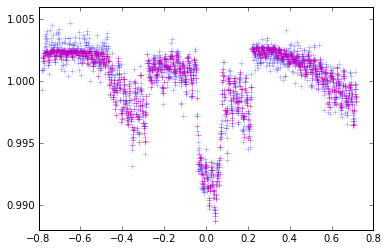

In [66]:
'what did the optimization give - probably nothing that makes sense '
print result
m1 = (transit_model(time,planet, xdata, ydata,middlex, middley, 
                    rp_ml, t0_ml, ax_true, w_true,inc_ml, ecc_true, lng_true, q1_ml,q2_ml,fp_true,
                    a_ml, a2_ml,b_ml, b2_ml, c_ml, d_ml, tau_rad_ml, wadv_ml))

plt.plot(time, flux, marker='+', linestyle='none', alpha=0.4)

plt.plot(time, m1, 'm+', linestyle='none',alpha = 0.8 )
plt.show()

In [68]:
"This is where the fitting happens!!! Can probably keep just the model and this piece "


truths = np.array([rp_true, t0_true, inc_true, q1_true, q2_true, a_true,a2_true, 
                   b_true, b2_true, c_true, d_true,tau_rad_true, wadv_true]) 

opt_result = np.array([rp_ml, t0_ml,inc_ml,q1_ml, q2_ml, a_ml, a2_ml,b_ml, b2_ml, c_ml,d_ml, tau_rad_ml, wadv_ml]) 


def lnlike(theta, t, planet, flux, x, y, ax, w, ecc, lng, middlex, middley,fp, yerr):
    rp, t0, inc, q1,q2, a, a2, b, b2, c, d, tau_rad, wadv = theta 
    #f is the fractional amount that we're underestimating the error
    model = transit_model(t,planet, x, y,  middlex, middley, rp, t0, ax, w, inc, ecc, 
                          lng, q1, q2 ,fp, a, a2, b, b2, c, d, tau_rad, wadv)
    inv_sigma2 = 1.0/(yerr**2 )
    return -0.5*(np.sum((flux-model)**2*inv_sigma2 - np.log(inv_sigma2)))

'probability dist to draw your samples from '
def lnprior(theta): 
    rp, t0,inc, q1, q2, a, a2, b, b2, c, d, tau_rad, wadv = theta 
    if (0 < rp < 1 and -1 < t0 < 1 and 
        80 < inc < 90 and 0< q1 < 1 and 0< q2 < 1 and  
        -10 < a < 10 and -10 < a2 < 10 and 
        -10 < b < 10 and -10< b2 < 10 and -10 < c < 10 and 
        -10 < d < 10 and 0.5 < tau_rad < 100 and -10 < wadv < 10  ): 
        return 0.0 
    
    return -np.inf

'total probability function'
def lnprob(theta, t, planet, flux, x, y, ax, w, ecc, lng, middlex, middley,fp, yerr): 
    lp = lnprior(theta) 
    if not np.isfinite(lp): 
        return -np.inf 
    return lp + lnlike(theta, t, planet, flux, x, y, ax, w, ecc, lng, middlex, middley,fp, yerr)

'give instructions for sampling'
#result["x"] 

ndim, nwalkers = 13, 100 
pos = [opt_result + 10**(-5)*np.random.randn(ndim) for i in range(nwalkers)] 
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(time,planet, flux, xdata, ydata, ax_true,
                                                              w_true, ecc_true, lng_true, middlex, middley,fp_true, yerror))

pos2, prob2, state2 = sampler.run_mcmc(pos, 100)

In [69]:
import time as t

# Clear and run the production chain.
print("Running MCMC...")
tic = t.clock()
pos3, prob3, state3 = sampler.run_mcmc(pos2, 500, rstate0=state2)
toc = t.clock()
print("Done.") 
print("time taken: ")
print(toc - tic)


Running MCMC...
Done.
time taken: 
2635.127306


In [70]:

print("Running MCMC...")
tic = t.clock()
pos4, prob4, state4 = sampler.run_mcmc(pos3, 1000, rstate0=state3)
toc = t.clock()
print("Done.") 
print("time taken: ")
print(toc - tic)



Running MCMC...
Done.
time taken: 
4880.993508


In [71]:
print("Running MCMC...")
tic = t.clock()
pos5,prob5,state5 = sampler.run_mcmc(pos4, 2000, rstate0=state4)
toc = t.clock()
print("Done.") 
print("time taken: ")
print(toc - tic)

Running MCMC...
Done.
time taken: 
9372.512742


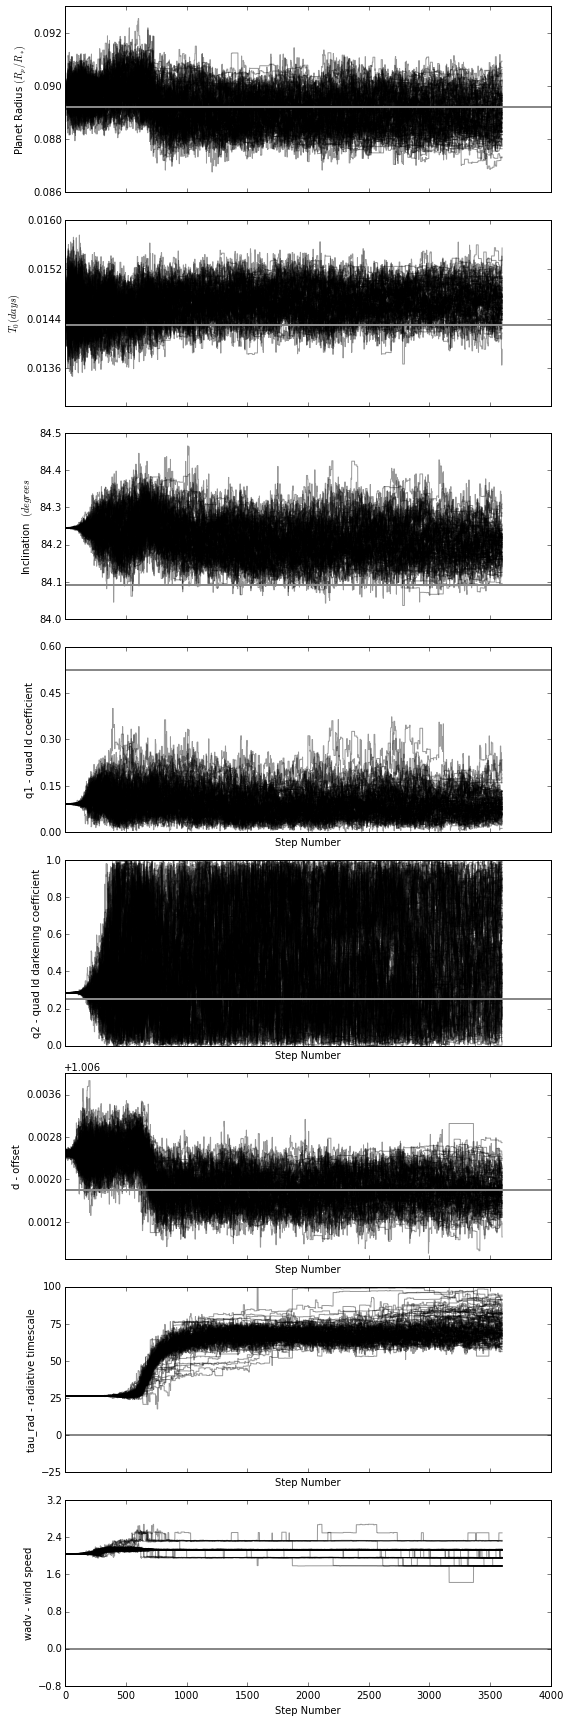

In [72]:
"""The rest is representations of results """

'make the walkers plots'
plt.clf()
fig, axes = plt.subplots(8, 1, sharex=True, figsize=(8, 24))
axes[0].plot(sampler.chain[:, :,  0].T, color="k", alpha=0.4)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].axhline(rp_true, color="#888888", lw=2)
axes[0].set_ylabel("Planet Radius $(R_p/R_*)$")

axes[1].plot(sampler.chain[:, :,  1].T, color="k", alpha=0.4)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].axhline(t0_true, color="#888888", lw=2)
axes[1].set_ylabel("$T_0 (days)$")

axes[2].plot((sampler.chain[:, :,  2]).T, color="k", alpha=0.4)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(inc_true, color="#888888", lw=2)
axes[2].set_ylabel("Inclination  $(degrees$")


axes[3].plot((sampler.chain[:, :, 3]).T, color="k", alpha=0.4)
axes[3].yaxis.set_major_locator(MaxNLocator(5))
axes[3].axhline(q1_true, color="#888888", lw=2)
axes[3].set_ylabel("q1 - quad ld coefficient")
axes[3].set_xlabel("Step Number")

axes[4].plot((sampler.chain[:, :, 4]).T, color="k", alpha=0.4)
axes[4].yaxis.set_major_locator(MaxNLocator(5))
axes[4].axhline(q2_true, color="#888888", lw=2)
axes[4].set_ylabel("q2 - quad ld darkening coefficient")
axes[4].set_xlabel("Step Number")


axes[5].plot((sampler.chain[:, :, -3]).T, color="k", alpha=0.4)
axes[5].yaxis.set_major_locator(MaxNLocator(5))
axes[5].axhline(d_true, color="#888888", lw=2)
axes[5].set_ylabel("d - offset")
axes[5].set_xlabel("Step Number")

axes[6].plot((sampler.chain[:, :, -2]).T, color="k", alpha=0.4)
axes[6].yaxis.set_major_locator(MaxNLocator(5))
axes[6].axhline(a_true, color="#888888", lw=2)
axes[6].set_ylabel("tau_rad - radiative timescale")
axes[6].set_xlabel("Step Number")

axes[7].plot((sampler.chain[:, :, -1]).T, color="k", alpha=0.4)
axes[7].yaxis.set_major_locator(MaxNLocator(5))
axes[7].axhline(a_true, color="#888888", lw=2)
axes[7].set_ylabel("wadv - wind speed")
axes[7].set_xlabel("Step Number")


fig.tight_layout(h_pad=0.0)
fig.savefig("line-time_phase.pdf")

In [73]:
'get the results'


                                                
# Compute the quantiles.
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))
#samples[:, 13] = np.exp(samples[:, 13])

rp_mcmc, t0_mcmc,inc_mcmc, q1_mcmc,q2_mcmc,a_mcmc,a2_mcmc,b_mcmc,b2_mcmc,c_mcmc,d_mcmc, tau_rad_mcmc, wadv_mcmc = map(
    lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

results = rp_mcmc, t0_mcmc,inc_mcmc, q1_mcmc,q2_mcmc,a_mcmc,a2_mcmc,b_mcmc,b2_mcmc,c_mcmc,d_mcmc, tau_rad_mcmc, wadv_mcmc
np.savetxt('results_phase.out', results, 
           header = "rp, t0, inc, q1, q2, a, a2, b, b2, c, d, tau_rad, wadv, (+/-)")


np.savetxt('chains_phase.out', samples, 
           header = "rp, t0, inc, q1, q2, a, a2, b, b2, c, d, tau_rad, wadv, (+/-)")
 
print("""MCMC result:
    rp = {0[0]} +{0[1]} -{0[2]} (truth: {1})
    t0 = {2[0]} +{2[1]} -{2[2]} (truth: {3})
    
    inc = {4[0]} +{4[1]} -{4[2]} (truth: {5})
    
    q1 = {6[0]} +{6[1]} -{6[2]} (truth: {7})
    q2 = {8[0]} +{8[1]} -{8[2]} (truth: {9})
    a = {10[0]} +{10[1]} -{10[2]} (truth: {11})
    a2 = {12[0]} +{12[1]} -{12[2]} (truth: {13})
    b = {14[0]} +{14[1]} -{14[2]} (truth: {15})
    b2 = {16[0]} +{16[1]} -{16[2]} (truth: {17})
    c = {18[0]} +{18[1]} -{18[2]} (truth: {19})
    d = {20[0]} +{20[1]} -{20[2]} (truth: {21})
    tau_rad = {22[0]} +{22[1]} -{22[2]} (truth: {23})
    w_adv = {24[0]} +{24[1]} -{24[2]} (truth: {25})
    
    
""".format(rp_mcmc, rp_true, t0_mcmc, t0_true, 
           inc_mcmc, inc_true, q1_mcmc,q1_true,
           q2_mcmc,q2_true,
           a_mcmc, a_true, a2_mcmc, a2_true,
           b_mcmc, b_true,
           b2_mcmc, b2_true,c_mcmc, c_true,
           d_mcmc, d_true,  tau_rad_mcmc, 20, wadv_mcmc, 2
           ))  

print("Mean acceptance fraction: {0:.12f}"
                .format(np.mean(sampler.acceptance_fraction)))
print("autocorrelation time: ")
print(sampler.acor)

MCMC result:
    rp = 0.0889934929718 +0.000746703813336 -0.000708201593246 (truth: 0.0892)
    t0 = 0.0146858246605 +0.000259959846372 -0.00023847613188 (truth: 0.0143)
    
    inc = 84.2029846337 +0.0483951816035 -0.0437477012982 (truth: 84.09)
    
    q1 = 0.0826541568765 +0.0447283678475 -0.0325292995876 (truth: 0.524699052073)
    q2 = 0.479491275928 +0.341351654293 -0.322091182585 (truth: 0.248583527596)
    a = -0.0153965339273 +0.000850612744528 -0.000609110126956 (truth: -0.0168)
    a2 = -0.0662355795282 +0.00301570697999 -0.00301262613572 (truth: -0.0638)
    b = -0.336886355505 +0.019823686797 -0.0205900649769 (truth: -0.387)
    b2 = -0.246941613181 +0.00898544050852 -0.0105652419565 (truth: -0.282)
    c = 0.0624108460816 +0.0206100323955 -0.0217006297188 (truth: -0.023)
    d = 1.00779722337 +0.000322158044555 -0.000277299522058 (truth: 1.0078)
    tau_rad = 67.877579393 +7.22328695807 -4.63000924047 (truth: 20)
    w_adv = 2.12944749666 +0.00471589196287 -0.1655646625

In [57]:
samples.shape




(100000, 14)

In [74]:
u1 = 2*np.sqrt(q1_mcmc[0])*q2_mcmc[0]
u2 = np.sqrt(q1_mcmc[0])*(1-2*q2_mcmc[0])

print u1
print u2

0.275703992734
0.011792367028


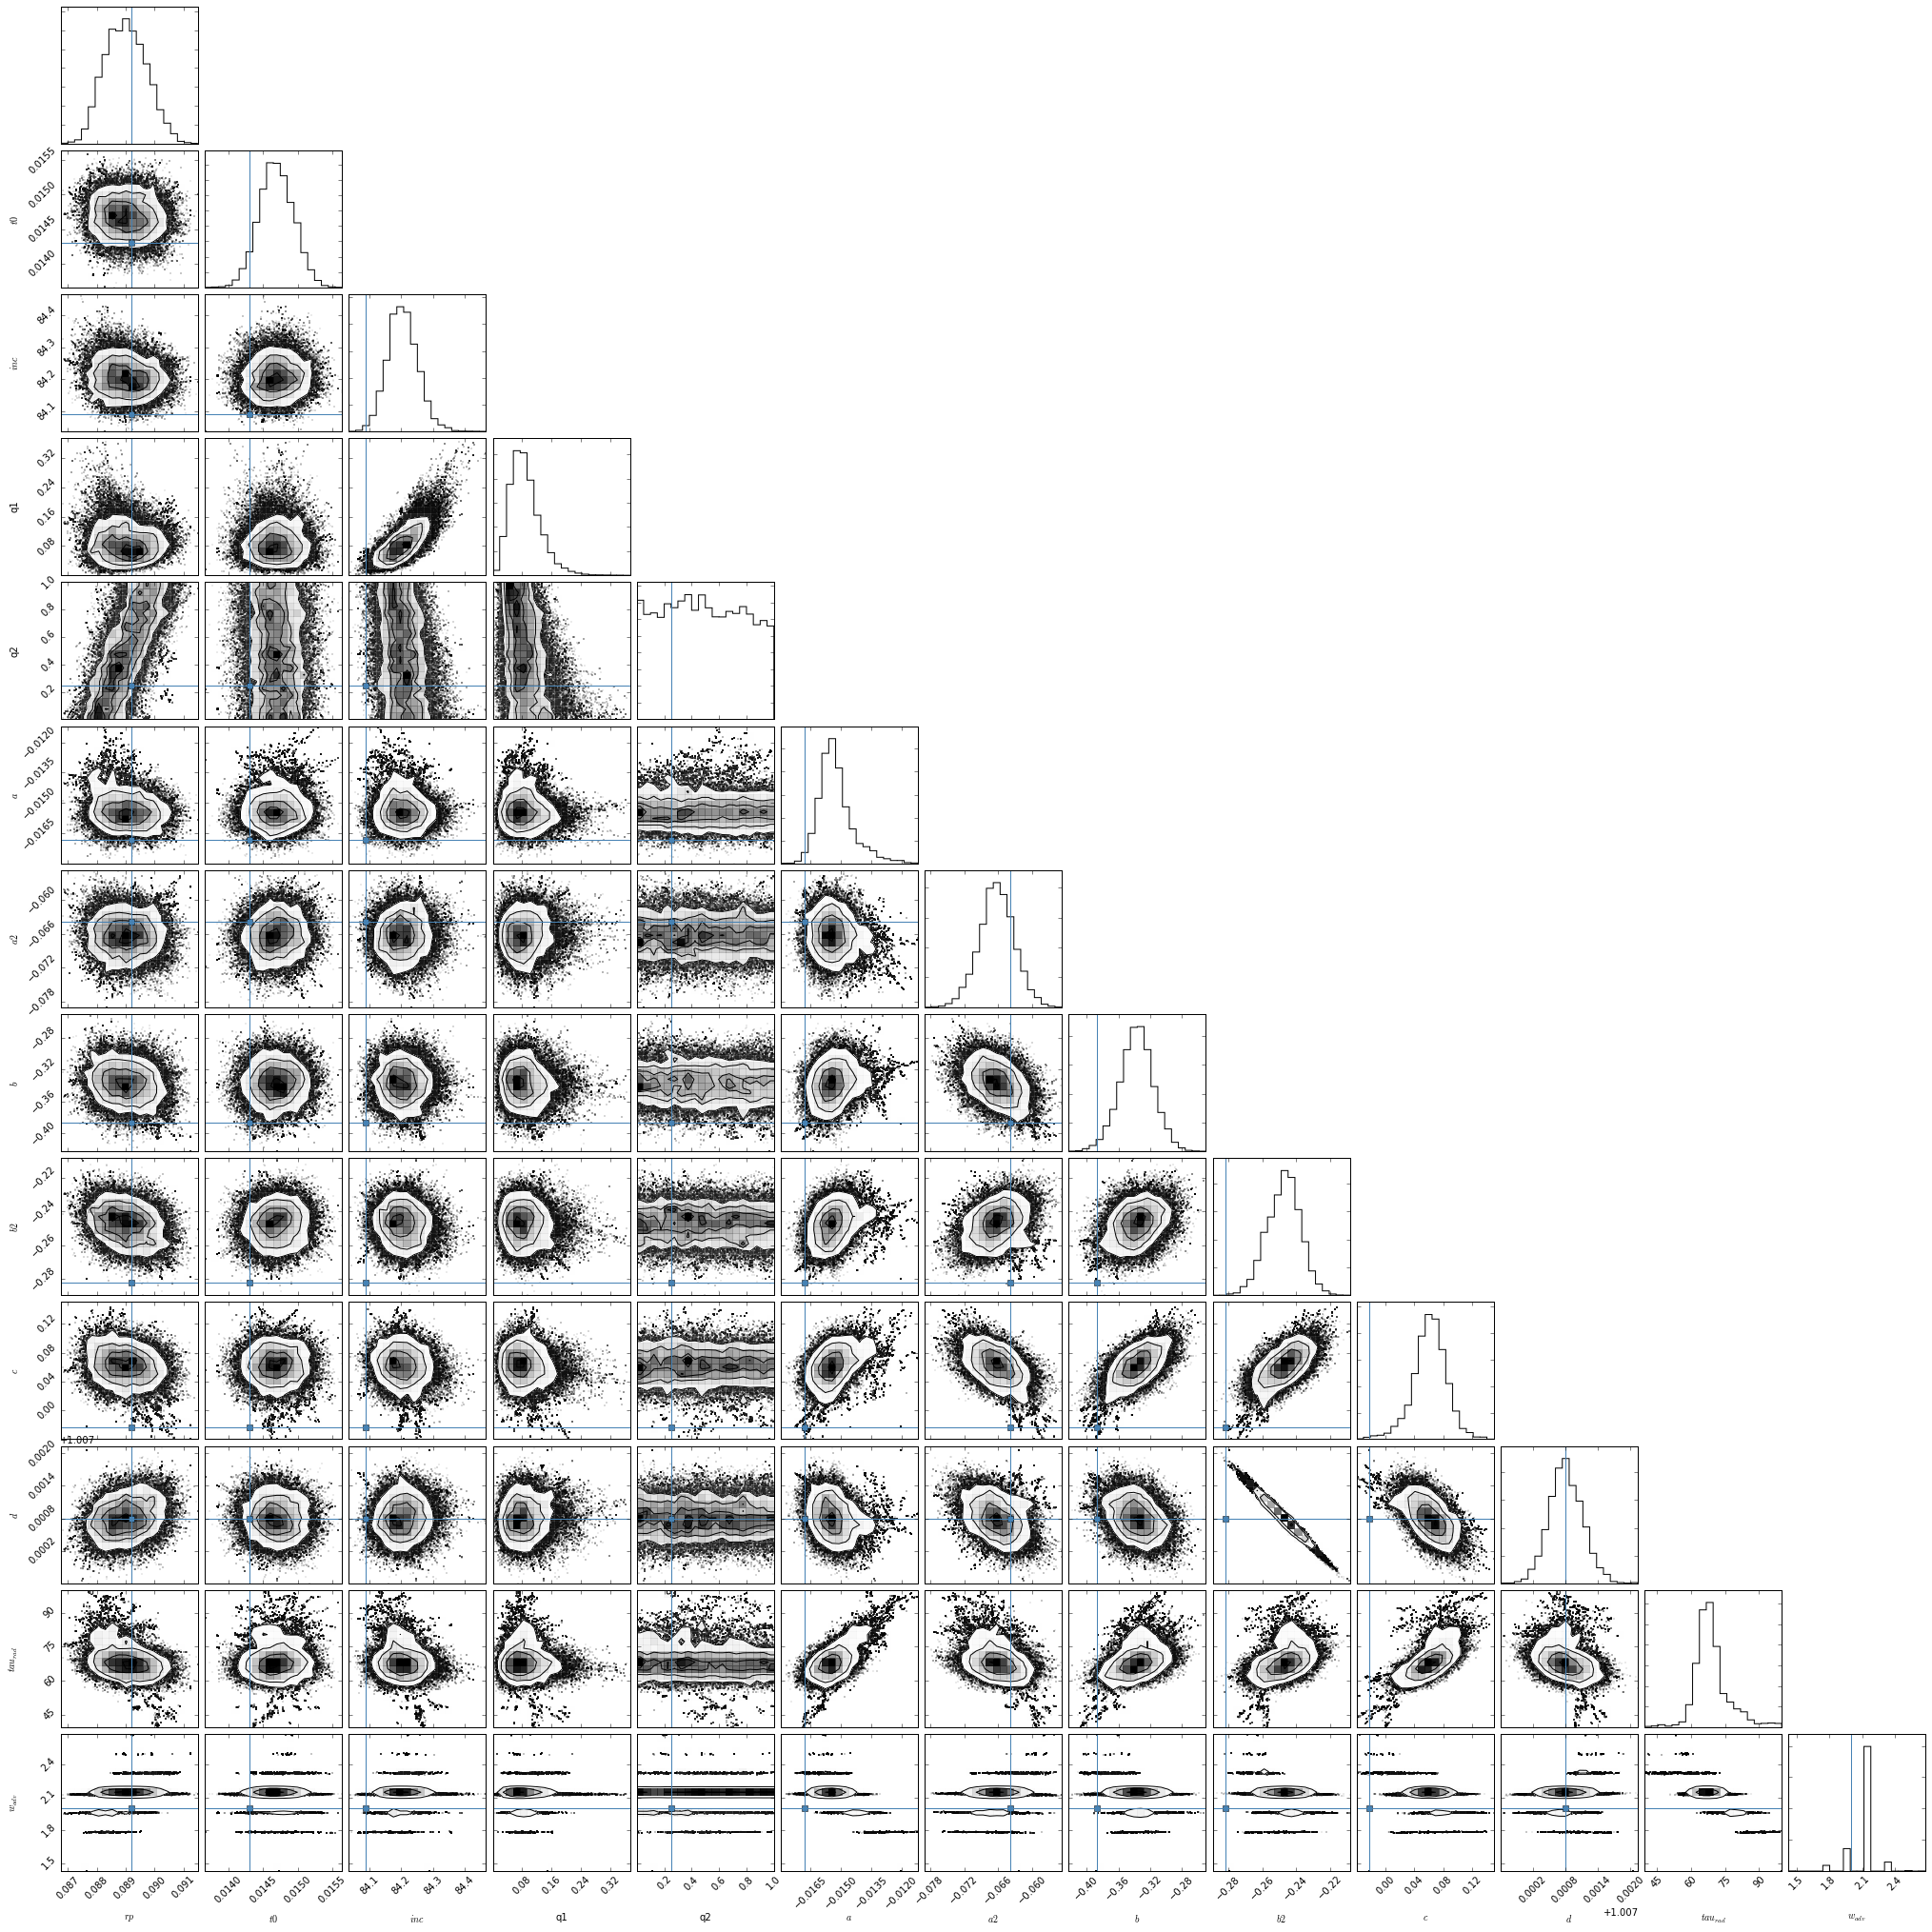

In [75]:
import corner
fig = corner.corner(samples, labels=["$rp$", "$t0$", 
                                     "$inc$", "q1",
                                     "q2",
                                     "$a$","$a2$","$b$","$b2$","$c$","$d$", "$tau_{rad}$", "$w_{adv}$"],
                      truths=[rp_true, t0_true, inc_true, q1_true, q2_true, a_true,a2_true, 
                   b_true, b2_true, c_true, d_true, tau_rad_true, wadv_true])
fig.savefig("triangle_phase.pdf")
    




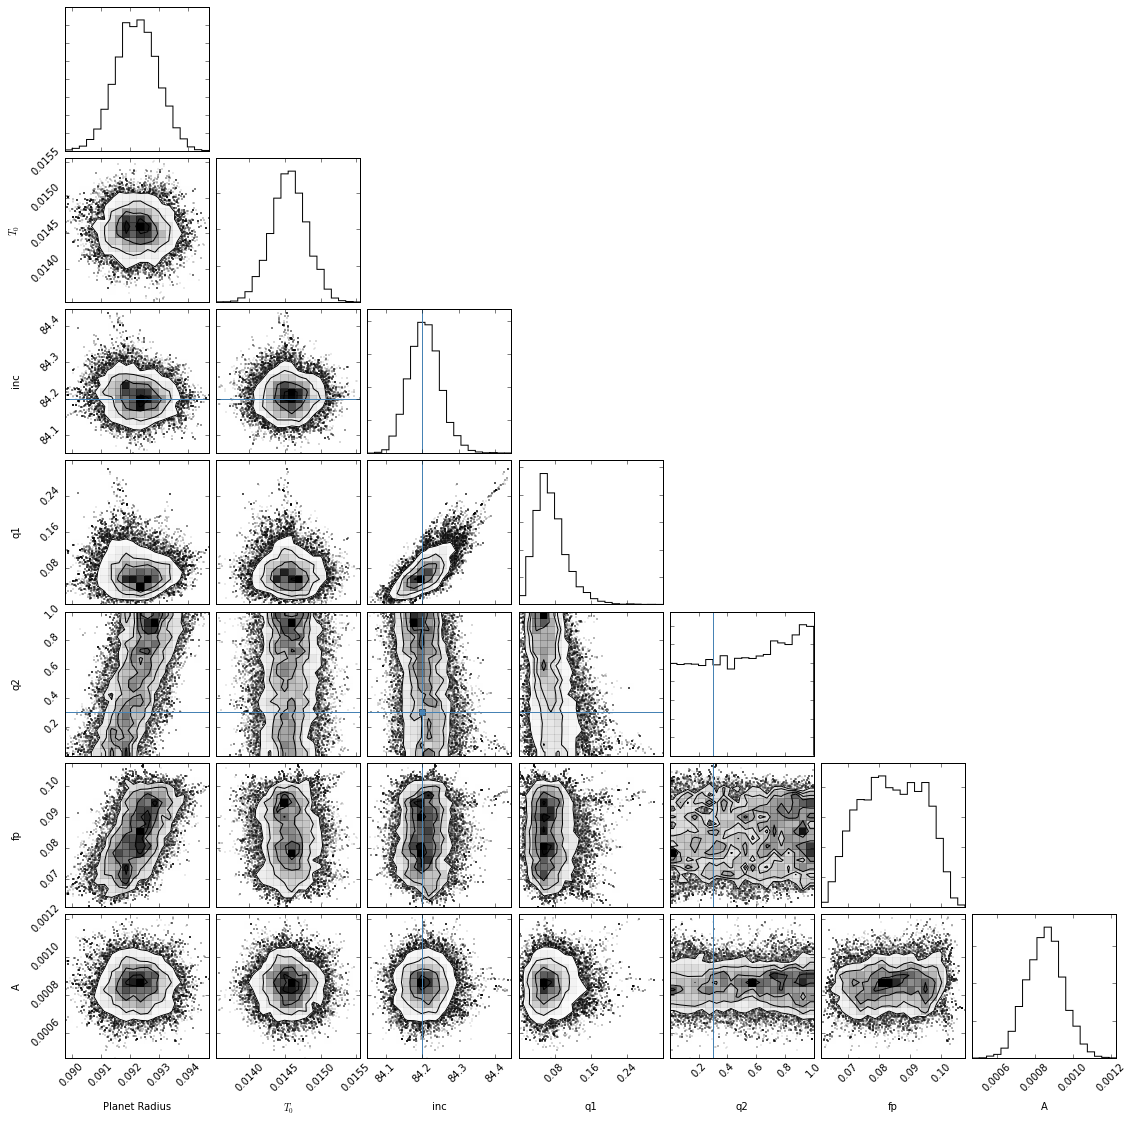

In [158]:

fig = corner.corner(samples[:, 0:7], labels=["Planet Radius", "$T_0$", "inc", "q1" , "q2", "fp","A"],
                                    
                      truths=[rp_true, t0_true, inc_true, q1_true, q2_true, fp_true, A_true])
fig.savefig("cornerplot_L.png")

In [7]:
(rp_mcmc, t0_mcmc,inc_mcmc, q1_mcmc,q2_mcmc,a_mcmc,
 a2_mcmc,b_mcmc,b2_mcmc,c_mcmc,d_mcmc, tau_rad_mcmc, wadv_mcmc)= np.loadtxt('results_phase.out', 
           skiprows = 1)

In [8]:
rp_mcmc


array([ 0.08899349,  0.0007467 ,  0.0007082 ])

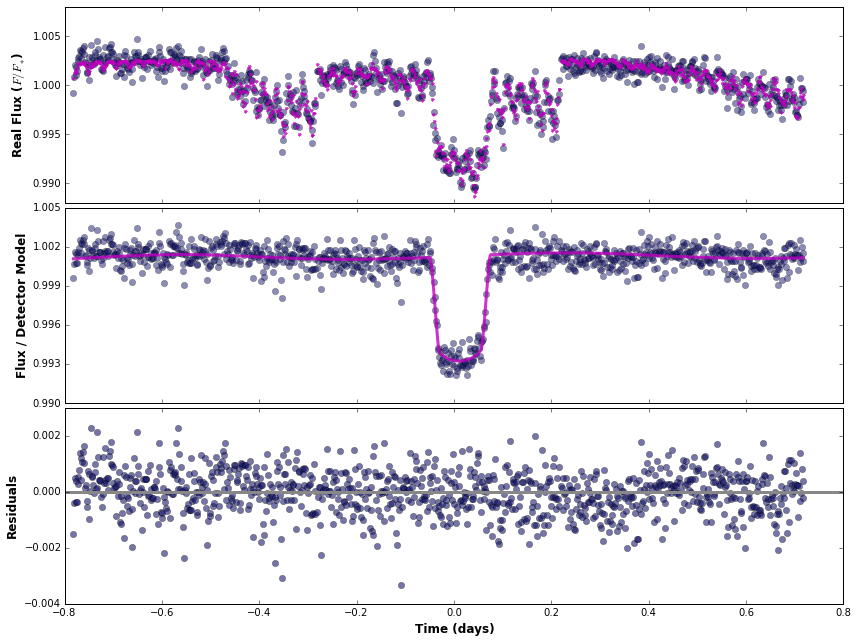

'kipping 2013 btter parametrization of limb darkening '

In [15]:
'try to plot the results'

# remember 'flux' is the original data 
full_model_mcmc = (transit_model(time, planet, xdata, ydata,middlex, middley, rp_mcmc[0], t0_mcmc[0],ax_true,w_true, inc_mcmc[0],
                            ecc_true,lng_true, q1_mcmc[0],q2_mcmc[0],fp_true,
                            a_mcmc[0],  a2_mcmc[0], b_mcmc[0], b2_mcmc[0], c_mcmc[0], d_mcmc[0],
                            tau_rad_mcmc[0],wadv_mcmc[0]))   
               
detector_mcmc = d_sens(xdata, ydata, middlex,middley, 
                    a_mcmc[0],  a2_mcmc[0],b_mcmc[0], b2_mcmc[0], c_mcmc[0], d_mcmc[0] )

curve_mcmc = full_model_mcmc / detector_mcmc

                   


fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 9))
axes[0].plot(time, flux, marker='o', color = 'midnightblue',linestyle='none',alpha=0.5)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].plot(time, full_model_mcmc, 'm.', linestyle='none',alpha=0.8)
#axes[0].set_ylim(1.05,1.10)
axes[0].set_ylabel("Real Flux ($F/F_*$)", fontsize = 12, fontweight = 'bold')

axes[1].plot(time, flux/detector_mcmc, marker='o', color = 'midnightblue', linestyle='none', alpha=0.5)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].plot(time, curve_mcmc, 'm',lw = 3, alpha=0.8)
#axes[1].set_ylim(0.980,1.020)
axes[1].set_ylabel("Flux / Detector Model", fontsize = 12, fontweight = 'bold')

axes[2].plot(time, flux- full_model_mcmc, marker='o',color = 'midnightblue',linestyle='none',alpha=0.6)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(0, color="#888888", lw=3)
axes[2].set_ylabel("Residuals", fontsize = 12, fontweight = 'bold')
axes[2].set_xlabel("Time (days)", fontsize = 12, fontweight = 'bold')

fig.tight_layout(h_pad=0.0)
fig.savefig('mcmcresult_L.png')
plt.show()


"""kipping 2013 btter parametrization of limb darkening """

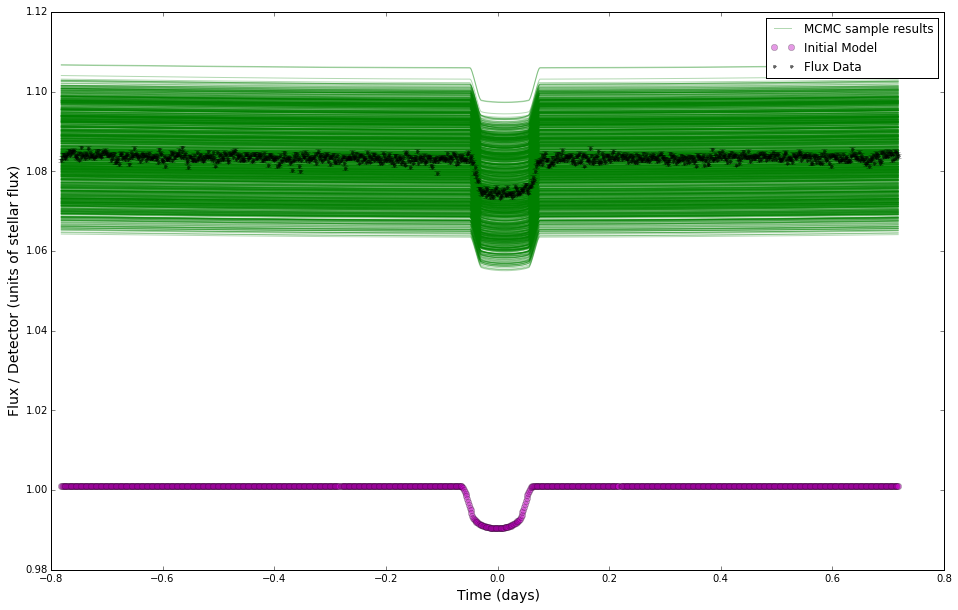

In [162]:
"""Figure that shows what random samples picked out of the walker positions gives, 
as well as the initial guess in purple """

fig = plt.figure(figsize = (16,10))
for rp, t0, inc, q1, q2, fp, A, a, a2, b, b2, c, d in samples[np.random.randint(len(samples), size=1000)]:
    green, = plt.plot(time,batman_model(time, rp, t0, ax_true, w_true, 
                     inc, ecc_true, lng_true,q1,q2, fp, A), color="g", alpha=0.3)


purple,=plt.plot(time, batman_model(time, rp_true, t0_true, 
                    ax_true, w_true, inc_true, ecc_true, lng_true, q1_true,q2_true, fp_true, A_true), 
                 color="m",marker='o', linestyle="None", alpha=0.4)
black, erropr, a, = plt.errorbar(time, flux/dsens_mcmc, yerr=yerror, fmt=".k", alpha=0.6)
#plt.title("MCMC Results(green), Model(purple), Model+Noise = Simulated Data(errorbars)").set_fontsize(20)
plt.xlabel("Time (days)").set_fontsize(14)
plt.ylabel("Flux / Detector (units of stellar flux)").set_fontsize(14)
plt.legend([green, purple,black], ['MCMC sample results','Initial Model','Flux Data'] )
plt.show()
fig.savefig("purple_and_green_results_L")

In [174]:
"""BIC - smaller one is better"""

def lnlike(theta, t, flux, x, y, ax, w, ecc, lng, middlex, middley, yerr):
    rp, t0, inc, q1,q2, fp, A, a, a2, b, b2, c, d = theta 
    #f is the fractional amount that we're underestimating the error
    model = transit_model(t, x, y,  middlex, middley, rp, t0, ax, w, inc, ecc, lng, q1,q2 ,fp, A, a, a2, b, b2, c, d)
    inv_sigma2 = 1.0/(yerr**2 )
    return -0.5*(np.sum((flux-model)**2*inv_sigma2 - np.log(inv_sigma2)))

thetaQ2 = (rp_mcmc[0], t0_mcmc[0],inc_mcmc[0],
                             q1_mcmc[0],q2_mcmc[0],fp_mcmc[0], A_mcmc[0],
                            a_mcmc[0],  a2_mcmc[0], b_mcmc[0], b2_mcmc[0], c_mcmc[0], d_mcmc[0])
L22 = lnlike(thetaQ2, time[400:800:], flux[400:800:], xdata[400:800:], ydata[400:800:], 
             ax_true, w_true, ecc_true, lng_true, middlex, middley, yerror[400:800:] )

print "Likelihood:" , L22

BIC_Q2 = -2*(L22) + len(thetaQ2)*(np.log(len(flux)) - np.log(2*np.pi))

print "BIC value:" , BIC_Q2

Likelihood: 2543.2123078
BIC value: -5020.52920535


In [175]:
len(thetaQ2)*(np.log(len(flux) - np.log(2*np.pi)))

89.763873777604374